In [1]:
#x01_populationStatistics

In [2]:
# from chewc.chewc import *
# import torch
import torch.nn as nn
import torch.nn.functional as F
# import matplotlib.pyplot as plt

In [3]:


import torch
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation

device='cpu'

class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Population:
    def __init__(self, genome, haplotypes, device=device):
        self.genome = genome
        self.device = device
        self.phenotypes = None
        self.bvs = None
        self.haplotypes = haplotypes
        self.dosages = haplotypes.sum(dim=1).float()
        self.size = haplotypes.shape[0]
                
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device=device):
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean

        
def calculate_breeding_value(population_dosages, trait_effects, device = device):
    return torch.einsum('hjk,jk->h', population_dosages,trait_effects)

def truncation_selection(population, trait, top_percent):
    return torch.topk(population.phenotypes, top_percent).indices

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape    
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
    #crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * (1 - crossovers) + paternal * crossovers
    return progeny


def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population.dosages, trait.effects) 
    
    if breeding_values.var() == 0:
        print('phenotype: no var')
        environmental_variance = 0  
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var() 
    
    # Check if environmental_variance is zero before applying torch.sqrt and .clone()
    if environmental_variance == 0:
        environmental_noise = torch.zeros(breeding_values.shape, device=device)
    else:
        environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance).detach()
    
    population.breeding_values = breeding_values
    population.phenotypes = breeding_values + environmental_noise
#     def _create_random_haplotypes(self,num_individuals):
#         return torch.randint(0, 2, (num_individuals, *self.g.shape), device=self.device)
def create_random_pop(G, pop_size):
    return torch.randint(0, 2, (pop_size, *G.shape), device= device)

def update_pop(population, haplotype_pop_tensor):
    population.haplotypes = haplotype_pop_tensor
    population.dosages = haplotype_pop_tensor.sum(dim=1).float()
    return population

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
#     crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * torch.logical_not(crossovers) + paternal * crossovers
    return progeny

def breed(mother_tensor, father_tensor, recombination_rate=0.1):
    eggs = recombine(mother_tensor,recombination_rate)
    pollens = recombine(father_tensor,recombination_rate)
    return torch.stack((eggs,pollens), dim=1)

def create_pop(G, haplotypes):
    return Population(G, haplotypes=haplotypes)

def bv(P,T):
    P.breeding_values = calculate_breeding_value(P.dosages,T.effects)
    
def create_progeny(mother_gametes, father_gametes,reps = 1):
    progeny = []
    for _ in range(reps):
        # Randomly shuffle the gametes from each parent 
        shuffled_mother_indices = torch.randperm(mother_gametes.shape[0])
        shuffled_father_indices = torch.randperm(father_gametes.shape[0])

        # Select the shuffled gametes
        mother_gametes = mother_gametes[shuffled_mother_indices]
        father_gametes = father_gametes[shuffled_father_indices]

        # Stack the gametes to create progeny haplotypes
        progeny_haplotypes = torch.stack((mother_gametes, father_gametes),dim=1)
        progeny.append(progeny_haplotypes)
    return torch.vstack(progeny)


class MyNetwork(nn.Module):
    def __init__(self, L, P):
        super(MyNetwork, self).__init__()
        
        # Layers for input1 and input3
        self.fc1 = nn.Linear(L, 128)
        self.fc2 = nn.Linear(128, 64)
        
        # Layers for input2
        self.fc3 = nn.Linear(P, 128)
        self.fc4 = nn.Linear(128, 64)
        
        # Layers for the upper triangle of input_matrix
        self.fc_matrix = nn.Linear(L * (L + 1) // 2, 256)
        
        # Final fully connected layers
        self.fc_final1 = nn.Linear(64 * 3 + 256, 64)
        self.fc_final2 = nn.Linear(64, 5)  # Changed from 10 to 5 for a single choice with 5 values
    
    def forward(self, input1, input2, input3, input_matrix):
        
        # Process input1 and input3
        x1 = F.relu(self.fc1(input1))
        x1 = F.relu(self.fc2(x1))
        
        x3 = F.relu(self.fc1(input3))
        x3 = F.relu(self.fc2(x3))
        
        # Process input2
        x2 = F.relu(self.fc3(input2))
        x2 = F.relu(self.fc4(x2))
        
        # Process input_matrix
        indices = torch.triu_indices(input_matrix.size(1), input_matrix.size(2))
        upper_triangle = input_matrix[:, indices[0], indices[1]]
        x_matrix = F.relu(self.fc_matrix(upper_triangle))
        
        # Concatenate all features
        x = torch.cat((x1, x2, x3, x_matrix), dim=1)
        
        # Final fully connected layers
        x = F.relu(self.fc_final1(x))
        output = self.fc_final2(x)
        
        # Apply softmax to get probabilities for the single choice with 5 values
        output = F.softmax(output, dim=1)
        
        return output
    
    
def population_statistics(population_tensor):

    
    #Calculate the mean genotype value divided by 2 for each marker.
    def calculate_allele_frequencies(genotypes):
        num_individuals = genotypes.size(0)
        allele_frequencies = torch.mean(genotypes, dim=0) / 2.
        return allele_frequencies
    #Calculate the unique genotype counts and their frequencies.
    def calculate_genotype_frequencies(genotypes):
        num_individuals = genotypes.size(0)
        unique_genotypes, counts = torch.unique(genotypes, dim=0, return_counts=True)
        genotype_frequencies = counts.float() / num_individuals
        return unique_genotypes, genotype_frequencies
    #Calculate the proportion of heterozygous individuals at each marker.
    def calculate_heterozygosity(genotypes):
        num_individuals = genotypes.size(0)
        heterozygosity = torch.sum(genotypes == 1, dim=0).float() / num_individuals
        return heterozygosity
    #Calculate the frequency of the less common allele.
    def calculate_maf(genotypes):
        allele_frequencies = calculate_allele_frequencies(genotypes)
        maf = torch.minimum(allele_frequencies, 1 - allele_frequencies)
        return maf
    #Measure the degree of inbreeding based on observed and expected heterozygosity.
    def calculate_inbreeding_coefficient(genotypes):
        num_markers = genotypes.size(1)
        observed_heterozygosity = torch.sum(genotypes == 1, dim=1).float() / num_markers
        expected_heterozygosity = 2 * calculate_allele_frequencies(genotypes) * (1 - calculate_allele_frequencies(genotypes))
        average_expected_heterozygosity = torch.mean(expected_heterozygosity)
        inbreeding_coefficient = 1 - (observed_heterozygosity / average_expected_heterozygosity)
        return inbreeding_coefficient
    #Calculate the correlation matrix for the genotypes.
    def calculate_ld(genotypes):
        num_markers = genotypes.size(1)
        ld_matrix = torch.corrcoef(genotypes.T)
        return ld_matrix
    #Measure the genetic differentiation between subpopulations.
    def calculate_fst(genotypes, subpopulations):
        total_allele_frequencies = calculate_allele_frequencies(genotypes)
        subpop_allele_frequencies = [calculate_allele_frequencies(genotypes[subpop]) for subpop in subpopulations]
        ht = 2 * total_allele_frequencies * (1 - total_allele_frequencies)
        hs = torch.mean(torch.stack([2 * freq * (1 - freq) for freq in subpop_allele_frequencies]), dim=0)
        fst = (ht - hs) / ht
        return fst
    #Estimate the effective population size based on allele frequencies and genetic drift.
    def calculate_effective_population_size(genotypes):
        num_individuals = genotypes.size(0)
        allele_frequencies = calculate_allele_frequencies(genotypes)
        variance = torch.var(allele_frequencies)
        ne = (num_individuals - 1) / (2 * variance)
        return ne

    genotypes = population_tensor
    stats = {
        'allele_frequencies': calculate_allele_frequencies(genotypes),
        'genotype_frequencies': calculate_genotype_frequencies(genotypes),
        'heterozygosity': calculate_heterozygosity(genotypes),
        'maf': calculate_maf(genotypes),
        'inbreeding_coefficient': calculate_inbreeding_coefficient(genotypes),
        'ld_matrix': calculate_ld(genotypes),
        'effective_population_size': calculate_effective_population_size(genotypes)
    }
    return stats

class BreedingSimulation:
    def __init__(self, G, T, h2, reps, pop_size, max_generations=10, variance_threshold=1e-6):
        self.G = G
        self.T = T
        self.h2 = h2
        self.reps = reps
        self.pop_size = pop_size
        self.max_generations = max_generations
        self.variance_threshold = variance_threshold

        # Create and store the initial population
        self.initial_haplotypes = create_random_pop(G, pop_size)
        self.initial_population = create_pop(G, self.initial_haplotypes)
        phenotype(self.initial_population, self.T, self.h2)

        # Initialize current population
        self.population = self.initial_population
        self.history = []
        self.current_generation = 0
        
    def step(self, actions):
        # Log current population
        current_state = self.get_state()
        self.track_data(actions, self.calculate_reward())

        # Select parents based on actions
        selected_parent_indices = self.select_parents(actions)
        selected = self.population.haplotypes[selected_parent_indices]

        # Breeding
        m = recombine(selected)  # Mother gametes
        f = recombine(selected)  # Father gametes
        progeny = create_progeny(m, f, reps=action2[torch.argmax(actions)])  # Create progeny

        # Create new population from progeny
        new_pop = create_pop(self.G, progeny)
        phenotype(new_pop, self.T, self.h2)

        # Switch current population to progeny population
        self.population = new_pop

        # Calculate reward based on new population
        reward = self.calculate_reward()

        # Get new state
        new_state = self.get_state()

        # Increment generation counter
        self.current_generation += 1

        # Check if episode is done
        done = self.is_done()

        return new_state, reward, done

    def select_parents(self, actions):
        if self.population.phenotypes is None:
            phenotype(self.population, self.T, self.h2)

        parents = torch.topk(self.population.phenotypes, action1[torch.argmax(actions)]).indices
        
        return parents

    def calculate_reward(self):
        # Define how to calculate the reward based on your objective. 
        # Example: Improvement in average trait value
        return self.population.phenotypes.mean()
    
    def is_done(self):
        # Check if max generations reached or phenotypic variance is too low
        if self.current_generation >= self.max_generations:
            return True
        if self.population.phenotypes.var() < self.variance_threshold:
            return True
        return False


    def reset(self):
        # Reset to the initial population
        self.population = create_pop(self.G, self.initial_haplotypes.clone())
        phenotype(self.population, self.T, self.h2)
        self.history = []
        self.current_generation = 0
        return self.get_state()
    
    def get_state(self):
        # Calculate population statistics here
        n_ind, n_chr, n_loci = self.population.haplotypes.sum(dim=1).shape
        pop_stat_in  = self.population.haplotypes.sum(dim=1).view((n_ind, n_chr* n_loci))
        pop_stat = population_statistics(pop_stat_in.float())

        # Create a dictionary to hold state features
        state = {
            'avg_phenotype': self.population.phenotypes.mean(),
            'phenotype_variance': self.population.phenotypes.var(),
            'avg_breeding_value': self.population.breeding_values.mean(),
            'heterozygosity': pop_stat['heterozygosity'],
#             'allele_frequencies': pop_stat['allele_frequencies'],
            'maf': pop_stat['maf'], # Assuming your model uses the whole maf vector
            'inbreeding_coefficient': pop_stat['inbreeding_coefficient'],
            'ld_matrix': pop_stat['ld_matrix'],
            'genotype_frequencies': pop_stat['genotype_frequencies'][1]
            # Add any other relevant features from pop_stat
        }
        return state

    def track_data(self, actions, reward):
        # Reuse state features from get_state()
        state = self.get_state()
        gen_data = {
            'generation': len(self.history),
            'avg_phenotype': state['avg_phenotype'].item(),
            'phenotype_variance': state['phenotype_variance'].item(),
            'avg_breeding_value': state['avg_breeding_value'].item(),
            'actions': actions,
            'reward': reward.item(),
            'n_ind': self.pop_size,  # Assuming 'n_ind' is calculated in get_state()
            'heterozygosity': state['heterozygosity'].mean(),
#             'allele_frequencies': state['allele_frequencies'].mean(),
            'maf': state['maf'].mean().mean(),
            'inbreeding_coefficient': state['inbreeding_coefficient'].mean().item(),
            # ... include other items from pop_stat as needed ...
        }
        self.history.append(gen_data)

    def plot_history(self):
        def normalize(data):
            min_val = min(data)
            max_val = max(data)
            return [(x - min_val) / (max_val - min_val) for x in data]
        generations = [d['generation'] for d in self.history]
        avg_phenotypes = [d['avg_phenotype'] for d in self.history]
        actions = [d['maf'] for d in self.history]
        
        avg_phenotypes = normalize(avg_phenotypes)
        actions = normalize(actions)
        plt.plot(generations, avg_phenotypes)
        plt.plot(generations, actions)
        plt.xlabel('Generation')
        plt.ylabel('Average Phenotype')
        plt.title('Breeding Progress')
        plt.show()
        

    
class RLAgent:
    def __init__(self, model):
        self.model = model
    
    def select_action(self,state):
        # Example: Convert state to tensor and feed it to the model to get actions
        
        input1 = state['maf'].unsqueeze(0)
        input2 = state['inbreeding_coefficient'].unsqueeze(0) 
        input3 = state['heterozygosity'].unsqueeze(0)
#         input4 = state['genotype_frequencies'].unsqueeze(0)
        input_matrix = state['ld_matrix'].unsqueeze(0)

        actions = self.model(input1, input2, input3, input_matrix)
        return actions
    
    
    #initialize the settings
n_chr = 5
n_loci = 100
founder_pop_size = 200

G = Genome(n_chr, n_loci)
founder_pop = create_pop(G, create_random_pop(G, founder_pop_size))
T = Trait(G, founder_pop, target_mean=0.0, target_variance=1.0)

sim = BreedingSimulation(G, T, h2=.99, reps=1, pop_size=founder_pop_size,max_generations=100)

model = MyNetwork(n_loci*n_chr, founder_pop_size)

agent = RLAgent(model)

# Define the actions
action1 = [5, 10, 20, 50, 100] # top k
action2 = [40, 20, 10, 4, 2] # number x


num_episodes=100
# Training loop
for episode in range(num_episodes):
    state = sim.reset()
    episode_reward = 0
    done = False
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, done = sim.step(action)
        # Here you would update your agent (e.g., store experience, update Q-values)
        episode_reward += reward
        state = next_state
    
    print(f"Episode {episode + 1} finished with reward: {episode_reward}")

Episode 1 finished with reward: 20.47016143798828
Episode 2 finished with reward: 21.19898796081543
Episode 3 finished with reward: 23.139944076538086
Episode 4 finished with reward: 22.096250534057617
Episode 5 finished with reward: 20.770248413085938
Episode 6 finished with reward: 39.219966888427734
Episode 7 finished with reward: 23.22631072998047
Episode 8 finished with reward: 28.091129302978516
Episode 9 finished with reward: 29.643047332763672
Episode 10 finished with reward: 22.287166595458984
phenotype: no var
Episode 11 finished with reward: 22.933990478515625
Episode 12 finished with reward: 29.913311004638672
Episode 13 finished with reward: 20.637788772583008
Episode 14 finished with reward: 18.260818481445312
phenotype: no var
Episode 15 finished with reward: 16.982547760009766
Episode 16 finished with reward: 33.59368896484375
Episode 17 finished with reward: 20.81548309326172
Episode 18 finished with reward: 20.93872833251953
Episode 19 finished with reward: 31.5458793

In [4]:
class EpisodeData:
    def __init__(self):
        self.final_reward = 0
        self.episode_length = 0
        self.final_avg_phenotype = 0
        self.final_phenotype_variance = 0
        self.final_avg_breeding_value = 0
        self.final_heterozygosity = 0
        self.final_maf = 0
        self.final_inbreeding_coefficient = 0
        self.actions_taken = []

class MetaAnalysis:
    def __init__(self):
        self.episodes = []

    def add_episode(self, episode_data):
        self.episodes.append(episode_data)

    def get_summary(self):
        # Implement summary statistics here
        pass

In [5]:
meta_analysis = MetaAnalysis()

for episode in range(num_episodes):
    state = sim.reset()
    episode_data = EpisodeData()
    episode_reward = 0
    done = False
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, done = sim.step(action)
        episode_reward += reward
        episode_data.actions_taken.append(action.detach().cpu().numpy())
        state = next_state
    
    # Capture final state information
    episode_data.final_reward = episode_reward
    episode_data.episode_length = sim.current_generation
    episode_data.final_avg_phenotype = state['avg_phenotype'].item()
    episode_data.final_phenotype_variance = state['phenotype_variance'].item()
    episode_data.final_avg_breeding_value = state['avg_breeding_value'].item()
    episode_data.final_heterozygosity = state['heterozygosity'].mean().item()
    episode_data.final_maf = state['maf'].mean().item()
    episode_data.final_inbreeding_coefficient = state['inbreeding_coefficient'].mean().item()
    
    meta_analysis.add_episode(episode_data)
    
    print(f"Episode {episode + 1} finished with reward: {episode_reward}")

Episode 1 finished with reward: 24.820268630981445
Episode 2 finished with reward: 33.96517562866211
phenotype: no var
Episode 3 finished with reward: 24.425872802734375
Episode 4 finished with reward: 31.376312255859375
Episode 5 finished with reward: 23.362546920776367
Episode 6 finished with reward: 26.748197555541992
Episode 7 finished with reward: 27.781620025634766
Episode 8 finished with reward: 14.939523696899414
Episode 9 finished with reward: 17.802303314208984
phenotype: no var
Episode 10 finished with reward: 26.384571075439453
phenotype: no var
Episode 11 finished with reward: 18.57962417602539
phenotype: no var
Episode 12 finished with reward: 18.754859924316406
Episode 13 finished with reward: 30.104263305664062
Episode 14 finished with reward: 25.90912628173828
Episode 15 finished with reward: 23.991676330566406
Episode 16 finished with reward: 26.72423553466797
Episode 17 finished with reward: 25.216482162475586
Episode 18 finished with reward: 26.29342269897461
Episod

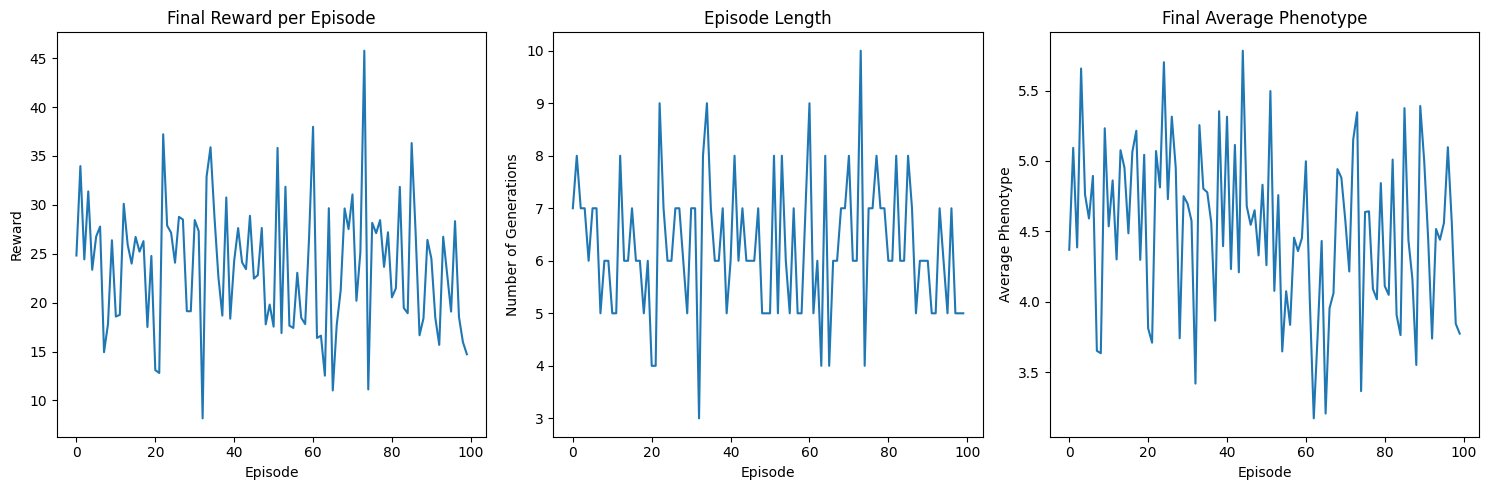

In [6]:
def analyze_learning_progress(meta_analysis):
    episode_rewards = [ep.final_reward for ep in meta_analysis.episodes]
    episode_lengths = [ep.episode_length for ep in meta_analysis.episodes]
    final_phenotypes = [ep.final_avg_phenotype for ep in meta_analysis.episodes]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(episode_rewards)
    plt.title('Final Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    
    plt.subplot(1, 3, 2)
    plt.plot(episode_lengths)
    plt.title('Episode Length')
    plt.xlabel('Episode')
    plt.ylabel('Number of Generations')
    
    plt.subplot(1, 3, 3)
    plt.plot(final_phenotypes)
    plt.title('Final Average Phenotype')
    plt.xlabel('Episode')
    plt.ylabel('Average Phenotype')
    
    plt.tight_layout()
    plt.show()

# After training
analyze_learning_progress(meta_analysis)